In [1]:
import json
import cv2
from matplotlib import pyplot as plt
import numpy as np
from boundary_sam.boundary_sam import BoundarySAM
from boundary_sam.utilities import get_annotations_for_image,generate_binary_masks,bounding_box, post_process,calculate_metrics

In [2]:
device = 'cuda'# only use gpu otherwise there is no point really. This method works for the huge backbone as we disscussed in the paper.
model_size = 'huge'

if model_size == 'huge':
    WEIGHTS_NAME = "sam_vit_h_4b8939.pth"
    model_type ='vit_h'
elif model_size == 'large':
    WEIGHTS_NAME = "sam_vit_l_0b3195.pth"
    model_type ='vit_l'
elif model_size == 'small':
    WEIGHTS_NAME = "sam_vit_b_01ec64.pth"
    model_type ='vit_b'
else: 
    print('model size got to be: huge, large or small')
    
path_to_weights = '/home/appuser/weights/'# here you put the path where SAM's weights are! 
sam_checkpoint = f"{path_to_weights}{WEIGHTS_NAME}"
SAM_ARGS = {'PPS':20,'IoUthresh':0.85,'SST':0.95}

bs = BoundarySAM(checkpoint = sam_checkpoint ,model_type = model_type, SAM_ARGS = SAM_ARGS)


/home/appuser/miniconda/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [9]:
pth_datasets = '/home/appuser/data/'
dataset_name = 'konya_cukurava/coco_konya_lowres/'
pth_dataset = f'{pth_datasets}{dataset_name}'
train_json_pth = f'{pth_dataset}annotations/train2016.json'
with open(train_json_pth)  as f:
    train_json = json.load(f)
train_images_pth = f'{pth_dataset}images/train2016/'

im_list = train_json['images']
print(len(im_list))


50


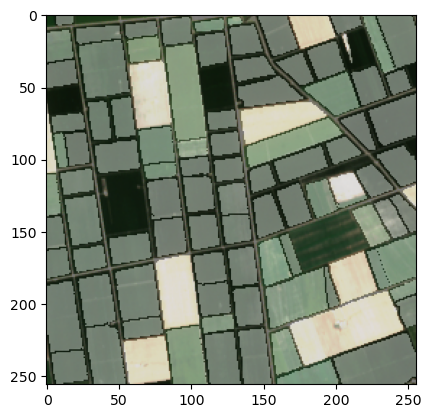

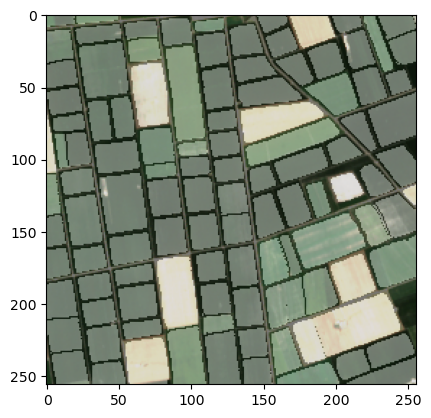

In [12]:
im_info = im_list[0]
im_pth = f'{train_images_pth}{im_info['file_name']}'
im = cv2.imread(im_pth)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
anns = get_annotations_for_image(im_info['file_name'],train_json)
im_width,im_hight,c = im.shape
image_size = (im_width,im_hight)
masks_gt = generate_binary_masks(anns, image_size)
masks_gt = [mask[:,:,0]>0 for mask in masks_gt]
masks_gt= [mask for mask in masks_gt   if (np.where(mask==True)[0]==255).sum()==0 and ( np.where(mask==True)[1]==255).sum()==0 and ( np.where(mask==True)[0]==0).sum()==0 and ( np.where(mask==True)[1]==0).sum()==0 ] 
masks_gt = [mask for mask in masks_gt if bounding_box(mask) is not None]

masks_w = bs.generate_masks_original(im)
masks_og = [x['segmentation']  for x in masks_w]
final_res_og = post_process(masks_w)
res_og = 100*np.stack((final_res_og,final_res_og,final_res_og),axis = 2)+im//2
plt.imshow(res_og)
plt.show()

masks_w = bs.generate_masks_enhanced(im/255)
final_res_pca = post_process(masks_w)
res_pca = 100*np.stack((final_res_pca,final_res_pca,final_res_pca),axis = 2)+im//2
plt.imshow(res_pca)
plt.show()




# 

In [ ]:
MASKS_gt = []
MASKS_og = []
MASKS_pca =[]
for idx, im_info in enumerate(im_list):
    im_pth = f'{train_images_pth}{im_info['file_name']}'
    im = cv2.imread(im_pth)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    anns = get_annotations_for_image(im_info['file_name'],train_json)

    im_width,im_hight,c = im.shape
    image_size = (im_width,im_hight)# Example image size (height, width)
    masks_gt = generate_binary_masks(anns, image_size)
    masks_gt = [mask[:,:,0]>0 for mask in masks_gt]
    masks_gt= [mask for mask in masks_gt   if (np.where(mask==True)[0]==255).sum()==0 and ( np.where(mask==True)[1]==255).sum()==0 and ( np.where(mask==True)[0]==0).sum()==0 and ( np.where(mask==True)[1]==0).sum()==0 ] 
    masks_gt = [mask for mask in masks_gt if bounding_box(mask) is not None]
    

    MASKS_gt.append(masks_gt)
    

    masks_w = bs.generate_masks_original(im)
    masks_og = [x['segmentation']  for x in masks_w]
    MASKS_og.append(masks_og)
    final_res_og = post_process(masks_w)
    masks_w = bs.generate_masks_enhanced(im/255)
    masks_pca = [x['segmentation']  for x in masks_w]
    MASKS_pca.append(masks_pca)
    final_res_pca = post_process(masks_w)



    print(f"{idx + 1}/{len(im_list)}")
    if idx + 1 >= 50:
        break
    # break
# 

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50


In [6]:
IoU_thresh = 0.25
metrics_og_konya = []
metrics_pca_konya = []
for idx, (masks_gt,masks_og,masks_pca) in enumerate(zip(MASKS_gt,MASKS_og,MASKS_pca)):
    us_imag_og,os_image_og,fn_ratio_og,iou_image_og = calculate_metrics(masks_gt,masks_og,IoU_thresh=IoU_thresh)
    us_imag_pca,os_image_pca,fn_ratio_pca,iou_image_pca =  calculate_metrics(masks_gt,masks_pca,IoU_thresh=IoU_thresh)
    metrics_og_konya.append([us_imag_og,os_image_og,fn_ratio_og,iou_image_og])
    metrics_pca_konya.append([us_imag_pca,os_image_pca,fn_ratio_pca,iou_image_pca])

In [7]:
100*np.mean(abs(np.asarray(metrics_og_konya)),axis=0)

array([19.81177384, 33.0951386 ,  7.17089087, 62.80909657])

In [8]:
100*np.mean(abs(np.asarray(metrics_pca_konya)),axis=0)

array([19.75545199, 31.31316963,  3.32770468, 63.08894672])